In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import numpy as np
import seaborn
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from datetime import datetime, timedelta
import sqlite3
!pip install "prettytable<3.10"


from google.colab import drive
drive.mount('/content/drive')

import os

# List contents of the root of your Google Drive
print(os.listdir('/content/drive/My Drive'))


  Attempting uninstall: prettytable
    Found existing installation: prettytable 3.16.0
    Uninstalling prettytable-3.16.0:
      Successfully uninstalled prettytable-3.16.0
Mounted at /content/drive
['FILEM', 'Nonlinear Dynamics Notes', 'presentasi wp gabung prefinal.pdf', 'rama photobooth', '12. Idul Adha', 'Untitled form (File responses)', 'Untitled form.gform', 'Logo_KJRI Frankfurt.jpg', 'Logo_KBRI Berlin.jpg', '26. 1st PPIM Forum', '27. PodcastMü 1023', 'Copy of programheft (Final) revisi_1 (p.2).png', 'Logo IKA Swadaya PPIM', 'sertif_versi1_Part14.pdf', 'sertif_versi1_Part2.pdf', 'sertif_versi1_Part60.pdf', 'sertif_versi1_Part65.pdf', 'sertif_versi1_Part89.pdf', 'sertif_versi1_Part82.pdf', 'sertif_versi1_Part140.pdf', 'sertif_versi1_Part149.pdf', 'sertif_versi1_Part143.pdf', 'sertif_versi1_Part142.pdf', 'grid_1.jpg', 'grid_2.jpg', 'grid_3.jpg', 'SOP Request Desain.gdoc', 'Copy of Data Pengurus PPI Munich 23 24.gsheet', 'DSCF8882.JPG', 'DSCF8879.JPG', 'DSCF8884.JPG', 'DSCF8883.J

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
folder_path = '/content/drive/My Drive/Projects/NASA_Battery'

In [4]:
mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]
print(mat_files)

['B0026.mat', 'B0027.mat', 'B0025.mat', 'B0028.mat', 'B0007.mat', 'B0018.mat', 'B0006.mat', 'B0005.mat', 'B0055.mat', 'B0056.mat', 'B0054.mat', 'B0053.mat', 'B0031.mat', 'B0032.mat', 'B0033.mat', 'B0030.mat', 'B0029.mat', 'B0040.mat', 'B0041.mat', 'B0039.mat', 'B0036.mat', 'B0034.mat', 'B0038.mat', 'B0043.mat', 'B0044.mat', 'B0042.mat', 'B0048.mat', 'B0045.mat', 'B0047.mat', 'B0046.mat', 'B0049.mat', 'B0052.mat', 'B0051.mat', 'B0050.mat']


In [5]:
def matlab_datenum_to_datetime(matlab_vec):
    """
    Convert MATLAB date vector to Python datetime
    """
    year, month, day, hour, minute, second = matlab_vec
    return datetime(int(year), int(month), int(day),
                    int(hour), int(minute), int(second))


In [6]:
charge_frames = []
discharge_frames = []
eis_frames = []
rect_z = []

for file in mat_files:
    path = os.path.join(folder_path, file)
    data = loadmat(path, squeeze_me=True, struct_as_record=False)
    key = [k for k in data.keys() if not k.startswith('__')][0]
    cell_id = key

    attr = data[cell_id]
    cycles = attr.cycle

    for i, c in enumerate(cycles):
        cycle_start = matlab_datenum_to_datetime(c.time)
        m = c.data
        typ = c.type.lower()

        if typ == 'charge':
            n = len(m.Voltage_measured.flatten())
            df = pd.DataFrame({
                "Time_rel_s": m.Time.flatten(),
                "Voltage_measured": m.Voltage_measured.flatten(),
                "Current_measured": m.Current_measured.flatten(),
                "Temperature_measured": m.Temperature_measured.flatten(),
                "Voltage_charge": m.Voltage_charge.flatten(),
                "Current_charge": m.Current_charge.flatten(),
            })
            df["Cell_ID"] = [cell_id]*n
            df["Cycle_Number"] = [i]*n
            df["Ambient_Temperature"] = [c.ambient_temperature]*n
            df["Time_abs"] = df["Time_rel_s"].apply(lambda s: cycle_start + timedelta(seconds=float(s)))
            charge_frames.append(df)

        elif typ == 'discharge':
            n = len(m.Voltage_measured.flatten())
            df = pd.DataFrame({
                "Time_rel_s": m.Time.flatten(),
                "Voltage_measured": m.Voltage_measured.flatten(),
                "Current_measured": m.Current_measured.flatten(),
                "Temperature_measured": m.Temperature_measured.flatten(),
                "Voltage_charge": m.Voltage_load.flatten(),
                "Current_charge": m.Current_load.flatten()
                ,
            })
            df["Capacity"] = [m.Capacity]*n
            df["Cycle_Number"] = [i]*n
            df["Ambient_Temperature"] = [c.ambient_temperature]*n
            df["Cell_ID"] = [cell_id]*n
            df["Time_abs"] = df["Time_rel_s"].apply(lambda s: cycle_start + timedelta(seconds=float(s)))
            discharge_frames.append(df)

        elif typ == 'impedance':
            n = len(m.Sense_current.flatten())

            df = pd.DataFrame({
                "Sense_current": m.Sense_current.flatten(),
                "Battery_current": m.Battery_current.flatten(),
                "Current_ratio": m.Current_ratio.flatten(),
                "Battery_impedance": m.Battery_impedance.flatten(),
                "Re": [m.Re] * n,
                "Rct": [m.Rct] * n,
                "Cycle_Number": [i] * n,
                "Time_abs": [cycle_start] * n,
                "Cell_ID": [cell_id] * n
            })
            df["Ambient_Temperature"] = [c.ambient_temperature]*n
            eis_frames.append(df)

            n1 = len(m.Rectified_Impedance.flatten())
            df1 = pd.DataFrame({
                "Rectified_Impedance": m.Rectified_Impedance.flatten(),
                "Re": [m.Re] * n1,
                "Rct": [m.Rct] * n1,
                "Cycle_Number": [i] * n1,
                "Time_abs": [cycle_start] * n1,
                "Cell_ID": [cell_id] * n1
            })
            df1["Ambient_Temperature"] = [c.ambient_temperature]*n1
            rect_z.append(df1)

charge_df = pd.concat(charge_frames, ignore_index=True)
discharge_df = pd.concat(discharge_frames, ignore_index=True)
eis_df = pd.concat(eis_frames, ignore_index=True)
rect_df = pd.concat(rect_z, ignore_index=True)
print(charge_df.head())
print(discharge_df.head())
print(eis_df.head())

   Time_rel_s  Voltage_measured  Current_measured  Temperature_measured  \
0       0.000          3.242725         -0.002567             26.860812   
1       2.516          2.832777         -3.071143             26.864620   
2       5.204          3.405361          1.515168             26.876455   
3       7.672          3.427104          1.515246             26.899741   
4      10.141          3.442242          1.516749             26.917418   

   Voltage_charge  Current_charge Cell_ID  Cycle_Number  Ambient_Temperature  \
0          -0.007          -0.001   B0026             1                   24   
1           1.337          -3.088   B0026             1                   24   
2           4.133           1.506   B0026             1                   24   
3           4.165           1.506   B0026             1                   24   
4           4.181           1.506   B0026             1                   24   

                 Time_abs  
0 2009-02-13 19:35:35.000  
1 2009-02-13

In [7]:
print("Charge Dataframe:")
print(charge_df.info())
print("\nDischarge Dataframe:")
print(discharge_df.info())
print("\nEIS Dataframe:")
print(eis_df.info())

Charge Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6512876 entries, 0 to 6512875
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Time_rel_s            float64       
 1   Voltage_measured      float64       
 2   Current_measured      float64       
 3   Temperature_measured  float64       
 4   Voltage_charge        float64       
 5   Current_charge        float64       
 6   Cell_ID               object        
 7   Cycle_Number          int64         
 8   Ambient_Temperature   int64         
 9   Time_abs              datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 496.9+ MB
None

Discharge Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770070 entries, 0 to 770069
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time_rel_s           

In [8]:
eis_df['Re_Sense_Current'] = eis_df['Sense_current'].apply(lambda x: x.real)
eis_df['Im_Sense_Current'] = eis_df['Sense_current'].apply(lambda x: x.imag)
eis_df['Re_Battery_Current'] = eis_df['Battery_current'].apply(lambda x: x.real)
eis_df['Im_Battery_Current'] = eis_df['Battery_current'].apply(lambda x: x.imag)
eis_df['Re_Current_Ratio'] = eis_df['Current_ratio'].apply(lambda x: x.real)
eis_df['Im_Current_Ratio'] = eis_df['Current_ratio'].apply(lambda x: x.imag)
eis_df['Re_Battery_Impedance'] = eis_df['Battery_impedance'].apply(lambda x: x.real)
eis_df['Im_Battery_Impedance'] = eis_df['Battery_impedance'].apply(lambda x: x.imag)
eis_df['R_Electrolyte'] = eis_df['Re'].apply(lambda x: x.real)
eis_df['R_Charge_Transfer'] = eis_df['Rct'].apply(lambda x: x.real)
rect_df['Re_Rectified_Impedance'] = rect_df['Rectified_Impedance'].apply(lambda x: x.real)
rect_df['Im_Rectified_Impedance'] = rect_df['Rectified_Impedance'].apply(lambda x: x.imag)
rect_df['R_Electrolyte'] = rect_df['Re'].apply(lambda x: x.real)
rect_df['R_Charge_Transfer'] = rect_df['Rct'].apply(lambda x: x.real)

eis_df.drop(columns=['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Re', 'Rct'], inplace=True)
rect_df.drop(columns=['Rectified_Impedance', 'Re', 'Rct'], inplace=True)

In [9]:
print("Charge Dataframe:")
print(charge_df.info())
print("\nDischarge Dataframe:")
print(discharge_df.info())
print("\nEIS Dataframe:")
print(eis_df.info())
print("\nRect Dataframe:")
print(rect_df.info())

Charge Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6512876 entries, 0 to 6512875
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Time_rel_s            float64       
 1   Voltage_measured      float64       
 2   Current_measured      float64       
 3   Temperature_measured  float64       
 4   Voltage_charge        float64       
 5   Current_charge        float64       
 6   Cell_ID               object        
 7   Cycle_Number          int64         
 8   Ambient_Temperature   int64         
 9   Time_abs              datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 496.9+ MB
None

Discharge Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770070 entries, 0 to 770069
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time_rel_s           

In [10]:
#Discharge Current Types
discharge_type = []
alter_241 = ['B0042', 'B0043', 'B0044']
alter_41 = ['B0041']
alter_4124 = ['B0038', 'B0039', 'B0040']
constant_1A = ['B0045', 'B0046', 'B0047', 'B0048']
constant_2A = ['B0005', 'B0006', 'B0007', 'B0018', 'B0036', 'B0049', 'B0050', 'B0051', 'B0052', 'B0053', 'B0054', 'B0055', 'B0056']
constant_4A = ['B0029', 'B0030', 'B0031', 'B0032', 'B0033', 'B0034']
square_4A = ['B0025', 'B0026', 'B0027', 'B0028']
for cell in discharge_df['Cell_ID']:
  if cell in alter_241:
    discharge_type.append('Alter_2-4-1')
  elif cell in alter_41:
    discharge_type.append('Alter_4-1')
  elif cell in alter_4124:
    discharge_type.append('Alter_4-1-2-4')
  elif cell in constant_1A:
    discharge_type.append('Constant_1A')
  elif cell in constant_2A:
    discharge_type.append('Constant_2A')
  elif cell in constant_4A:
    discharge_type.append('Constant_4A')
  elif cell in square_4A:
    discharge_type.append('Square_4A')

discharge_df['Discharge_Type'] = discharge_type

In [11]:
# Create a mask of rows that fail to convert to numeric
mask = pd.to_numeric(discharge_df['Capacity'], errors='coerce').isna()

# Filter only the bad rows
bad_rows = discharge_df[mask]

# Show a few of them
bad_rows.tail()


,Time_rel_s,Voltage_measured,Current_measured,Temperature_measured,Voltage_charge,Current_charge,Capacity,Cycle_Number,Ambient_Temperature,Cell_ID,Time_abs,Discharge_Type
770065,1665.172,0.226026,-0.001428,6.406155,0.000,0.0004,[],58,4,B0050,2010-08-29 18:08:29.172,Constant_2A
770066,1676.110,0.225996,-0.001639,6.417024,0.000,0.0006,[],58,4,B0050,2010-08-29 18:08:40.110,Constant_2A
770067,1686.985,0.226404,-0.001182,6.414361,0.000,0.0004,[],58,4,B0050,2010-08-29 18:08:50.985,Constant_2A
770068,1697.844,0.226002,-0.001541,6.429544,0.001,0.0004,[],58,4,B0050,2010-08-29 18:09:01.844,Constant_2A
770069,1708.860,0.226062,-0.000816,6.439289,0.000,0.0004,[],58,4,B0050,2010-08-29 18:09:12.860,Constant_2A


In [12]:
#State of Health = current capacity/max capacity
discharge_df['Capacity'] = pd.to_numeric(discharge_df['Capacity'], errors='coerce')
discharge_df = discharge_df.dropna(subset=['Capacity'])

discharge_df['SoH'] = (
    discharge_df
    .groupby('Cell_ID')['Capacity']
    .transform(lambda x: x / x.max())
)

In [13]:
discharge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 764674 entries, 0 to 769442
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time_rel_s            764674 non-null  float64       
 1   Voltage_measured      764674 non-null  float64       
 2   Current_measured      764674 non-null  float64       
 3   Temperature_measured  764674 non-null  float64       
 4   Voltage_charge        764674 non-null  float64       
 5   Current_charge        764674 non-null  float64       
 6   Capacity              764674 non-null  float64       
 7   Cycle_Number          764674 non-null  int64         
 8   Ambient_Temperature   764674 non-null  int64         
 9   Cell_ID               764674 non-null  object        
 10  Time_abs              764674 non-null  datetime64[ns]
 11  Discharge_Type        764674 non-null  object        
 12  SoH                   764674 non-null  float64       
dtypes: d

In [14]:
conn = sqlite3.connect('mydb.sqlite')

charge_df.to_sql('CHARGE', conn, index=False, if_exists='replace')
discharge_df.to_sql('DISCHARGE', conn, index=False, if_exists='replace')
eis_df.to_sql('IMPEDANCE', conn, index=False, if_exists='replace')


93888

In [15]:
%load_ext sql
%sql sqlite:///mydb.sqlite
%config SqlMagic.style = 'PLAIN_COLUMNS'


In [16]:
%%sql
SELECT COUNT(DISTINCT Discharge_Type)
FROM DISCHARGE;

 * sqlite:///mydb.sqlite
Done.


COUNT(DISTINCT Discharge_Type)
7


In [17]:
%%sql SELECT DISTINCT Discharge_Type FROM DISCHARGE

 * sqlite:///mydb.sqlite
Done.


Discharge_Type
Square_4A
Constant_2A
Constant_4A
Alter_4-1-2-4
Alter_4-1
Alter_2-4-1
Constant_1A


In [18]:
%%sql SELECT DISTINCT SoH FROM DISCHARGE
WHERE CELL_ID = 'B0005'

 * sqlite:///mydb.sqlite
Done.


SoH
1.0
0.9945272071416714
0.9886138595081705
0.9885671763794173
0.9882348178817771
0.9887821697485943
0.9885044855913476
0.9834468955151549
0.9829174345738104
0.982830935473199


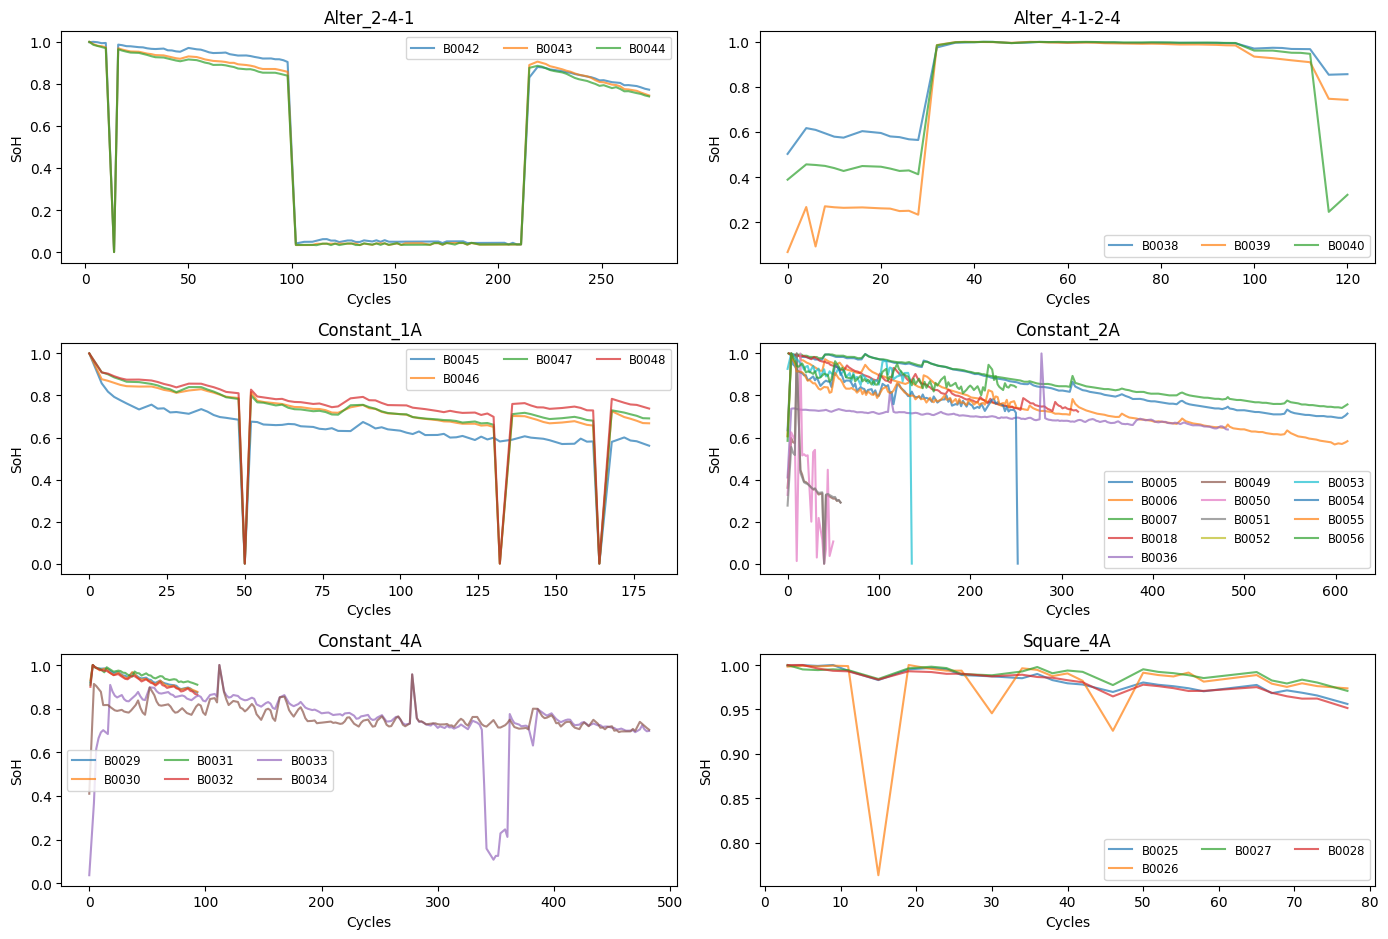

In [19]:
alt_241 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_2-4-1']
alt_4124 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_4-1-2-4']
const_1A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_1A']
const_2A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_2A']
const_4A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_4A']
square_4A = discharge_df[discharge_df['Discharge_Type'] == 'Square_4A']

discharge_types = {
    "Alter_2-4-1": alt_241,
    "Alter_4-1-2-4": alt_4124,
    "Constant_1A": const_1A,
    "Constant_2A": const_2A,
    "Constant_4A": const_4A,
    "Square_4A": square_4A,
}


fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (label, df) in zip(axes, discharge_types.items()):
    for cell_id, group in df.groupby("Cell_ID"):
        ax.plot(group["Cycle_Number"], group["SoH"], label=cell_id, alpha=0.7)
    ax.set_title(label)
    ax.set_xlabel("Cycles")
    ax.set_ylabel("SoH")
    ax.legend(fontsize="small", loc="best", ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


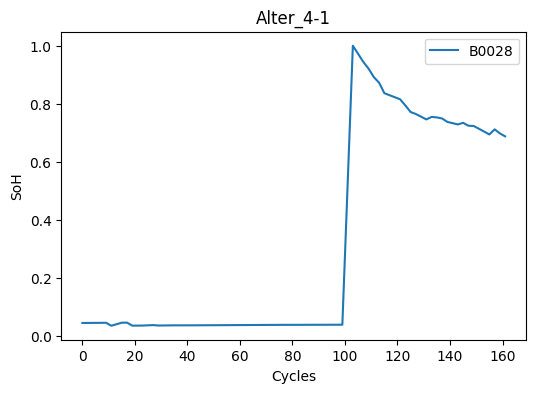

In [20]:
alt_41 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_4-1']

plt.figure(figsize=(6, 4))
plt.plot(alt_41['Cycle_Number'], alt_41['SoH'], label=cell_id)
plt.xlabel('Cycles')
plt.ylabel('SoH')
plt.title('Alter_4-1')
plt.legend()
plt.show()

Here, we see that some cells encountered some fatal errors that caused the measurement to end or experiencing end-of-life state (SoH < 70%) prematurely. While interesting, the goal of this project is to predict the state of health of normal cells, so we will remove those cells.

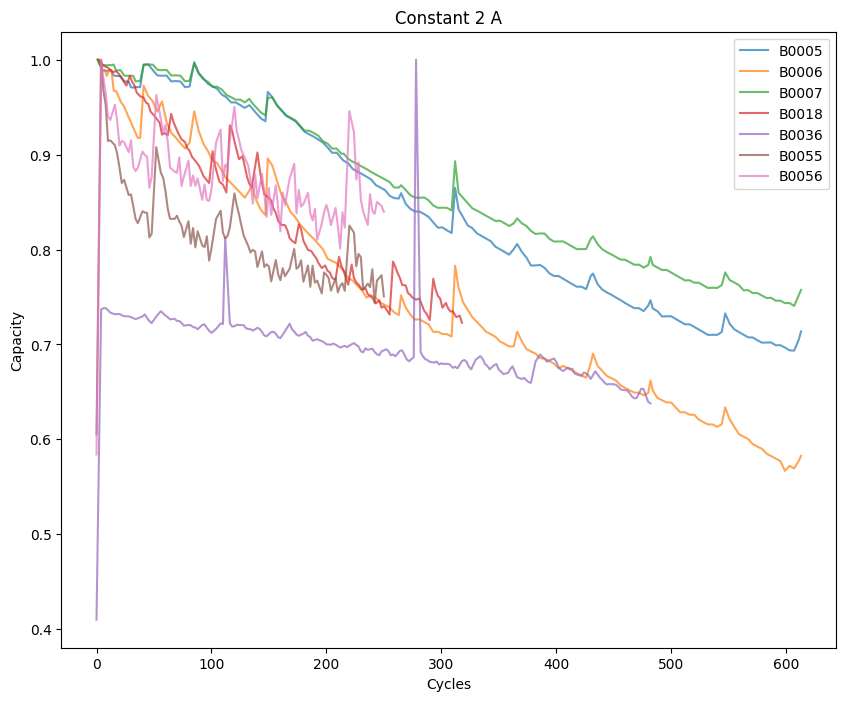

In [21]:
const_2A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_2A']
drop2A = ['B0036', 'B0005', 'B0006', 'B0007', 'B0018', 'B0055', 'B0056']
const_2A = const_2A[const_2A['Cell_ID'].isin(drop2A)]
const_2A.groupby('Cell_ID').count()
plt.figure(figsize=(10, 8))
for cell_id, group in const_2A.groupby("Cell_ID"):
        plt.plot(group["Cycle_Number"], group["SoH"], label=cell_id, alpha=0.7)
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.title('Constant 2 A')
plt.legend()
plt.show()

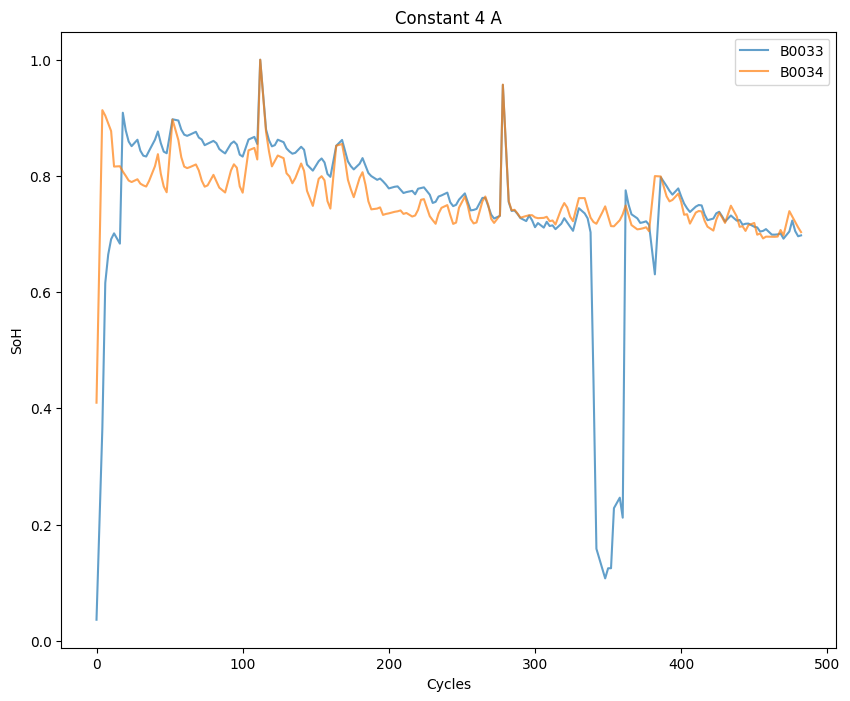

In [22]:
const_4A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_4A']
drop4A = ['B0029', 'B0030', 'B0031', 'B0032']
const_4A = const_4A[~const_4A['Cell_ID'].isin(drop4A)]
const_4A.groupby('Cell_ID').count()
plt.figure(figsize=(10, 8))
for cell_id, group in const_4A.groupby("Cell_ID"):
        plt.plot(group["Cycle_Number"], group["SoH"], label=cell_id, alpha=0.7)
plt.xlabel('Cycles')
plt.ylabel('SoH')
plt.title('Constant 4 A')
plt.legend()
plt.show()

To Drop: Batteries 29-32, 49-54

In [23]:
drop = ['B0029', 'B0030', 'B0031', 'B0032', 'B0049', 'B0050', 'B0051', 'B0052', 'B0053', 'B0054']

charge_df = charge_df[~charge_df['Cell_ID'].isin(drop)]
discharge_df = discharge_df[~discharge_df['Cell_ID'].isin(drop)]
eis_df = eis_df[~eis_df['Cell_ID'].isin(drop)]
rect_df = rect_df[~rect_df['Cell_ID'].isin(drop)]

In [24]:
print("Charge Dataframe:")
print(charge_df.info())
print("\nDischarge Dataframe:")
print(discharge_df.info())
print("\nEIS Dataframe:")
print(eis_df.info())
print("\nRect Dataframe:")
print(rect_df.info())

Charge Dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 5444268 entries, 0 to 6206967
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Time_rel_s            float64       
 1   Voltage_measured      float64       
 2   Current_measured      float64       
 3   Temperature_measured  float64       
 4   Voltage_charge        float64       
 5   Current_charge        float64       
 6   Cell_ID               object        
 7   Cycle_Number          int64         
 8   Ambient_Temperature   int64         
 9   Time_abs              datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 456.9+ MB
None

Discharge Dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 687175 entries, 0 to 746333
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time_rel_s            687175 no

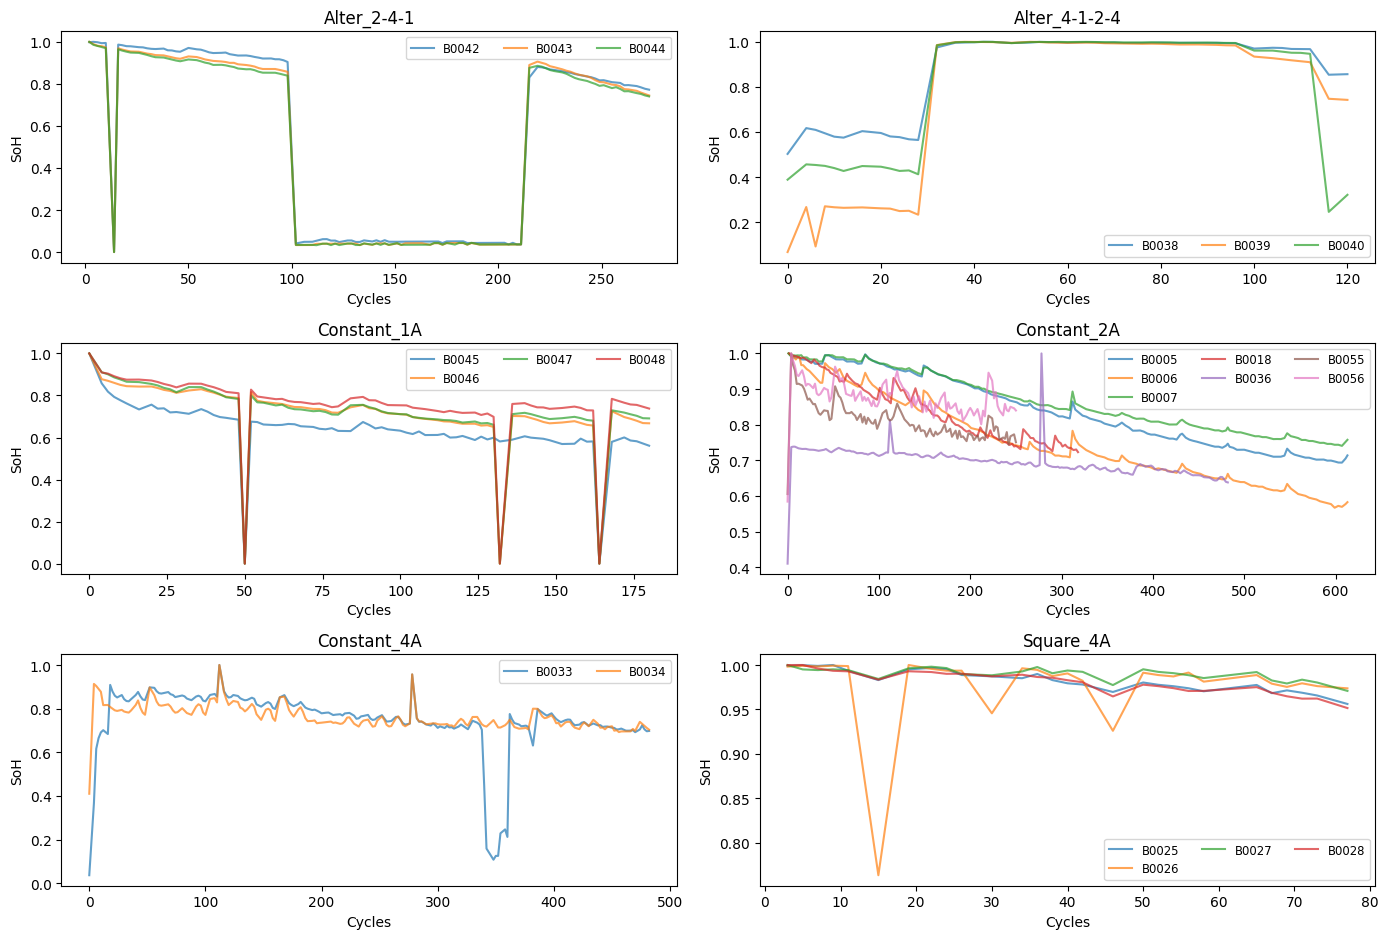

In [25]:
alt_241 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_2-4-1']
alt_4124 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_4-1-2-4']
const_1A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_1A']
const_2A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_2A']
const_4A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_4A']
square_4A = discharge_df[discharge_df['Discharge_Type'] == 'Square_4A']

discharge_types = {
    "Alter_2-4-1": alt_241,
    "Alter_4-1-2-4": alt_4124,
    "Constant_1A": const_1A,
    "Constant_2A": const_2A,
    "Constant_4A": const_4A,
    "Square_4A": square_4A,
}


fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (label, df) in zip(axes, discharge_types.items()):
    for cell_id, group in df.groupby("Cell_ID"):
        ax.plot(group["Cycle_Number"], group["SoH"], label=cell_id, alpha=0.7)
    ax.set_title(label)
    ax.set_xlabel("Cycles")
    ax.set_ylabel("SoH")
    ax.legend(fontsize="small", loc="best", ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [26]:
#Check the correlation matrix
numeric_cols = discharge_df.select_dtypes(include='number')
disc_corr_mat = numeric_cols.corr()
disc_corr_mat

,Time_rel_s,Voltage_measured,Current_measured,Temperature_measured,Voltage_charge,Current_charge,Capacity,Cycle_Number,Ambient_Temperature,SoH
Time_rel_s,1.000000,-0.349796,0.439816,0.062183,-0.236222,-0.381211,0.181575,-0.213378,0.070194,0.267947
Voltage_measured,-0.349796,1.000000,0.400522,-0.090255,0.191238,-0.387048,0.070457,-0.041045,0.154336,0.025644
Current_measured,0.439816,0.400522,1.000000,-0.223803,-0.200369,-0.865028,-0.118328,-0.129788,-0.126988,-0.005080
Temperature_measured,0.062183,-0.090255,-0.223803,1.000000,-0.157159,0.174075,0.537887,0.142910,0.908720,0.296155
Voltage_charge,-0.236222,0.191238,-0.200369,-0.157159,1.000000,0.143407,0.250252,-0.076828,0.028559,0.267276
Current_charge,-0.381211,-0.387048,-0.865028,0.174075,0.143407,1.000000,0.012889,0.186527,0.083795,-0.070018
Capacity,0.181575,0.070457,-0.118328,0.537887,0.250252,0.012889,1.000000,-0.132983,0.613353,0.827608
Cycle_Number,-0.213378,-0.041045,-0.129788,0.142910,-0.076828,0.186527,-0.132983,1.000000,0.067600,-0.338317
Ambient_Temperature,0.070194,0.154336,-0.126988,0.908720,0.028559,0.083795,0.613353,0.067600,1.000000,0.376794
SoH,0.267947,0.025644,-0.005080,0.296155,0.267276,-0.070018,0.827608,-0.338317,0.376794,1.000000


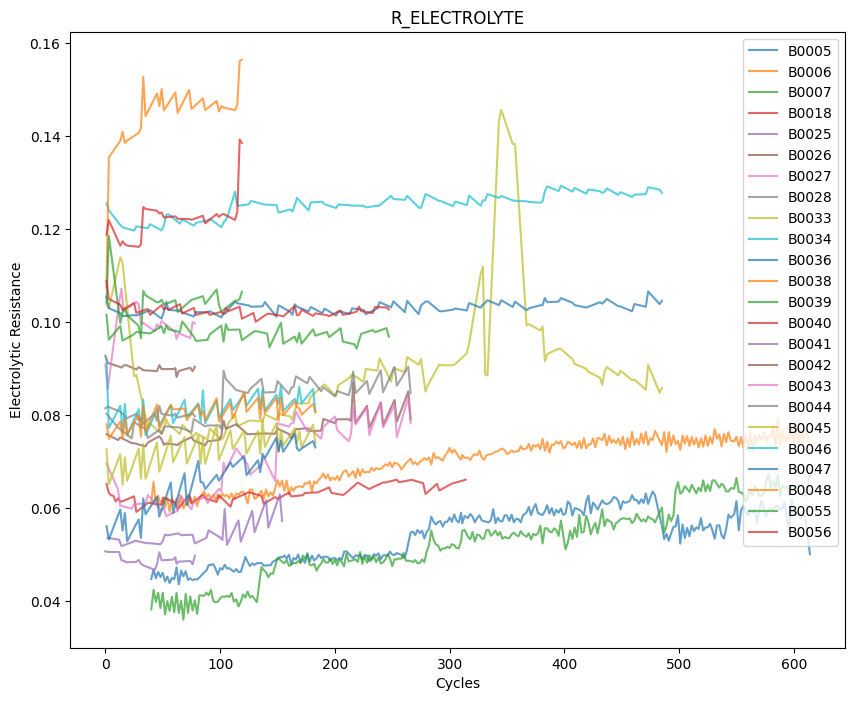

In [27]:
plt.figure(figsize=(10, 8))
for cell_id, group in eis_df.groupby("Cell_ID"):
        plt.plot(group["Cycle_Number"], group["R_Electrolyte"], label=cell_id, alpha=0.7)
plt.xlabel('Cycles')
plt.ylabel('Electrolytic Resistance')
plt.title('R_ELECTROLYTE')
plt.legend()
plt.show()

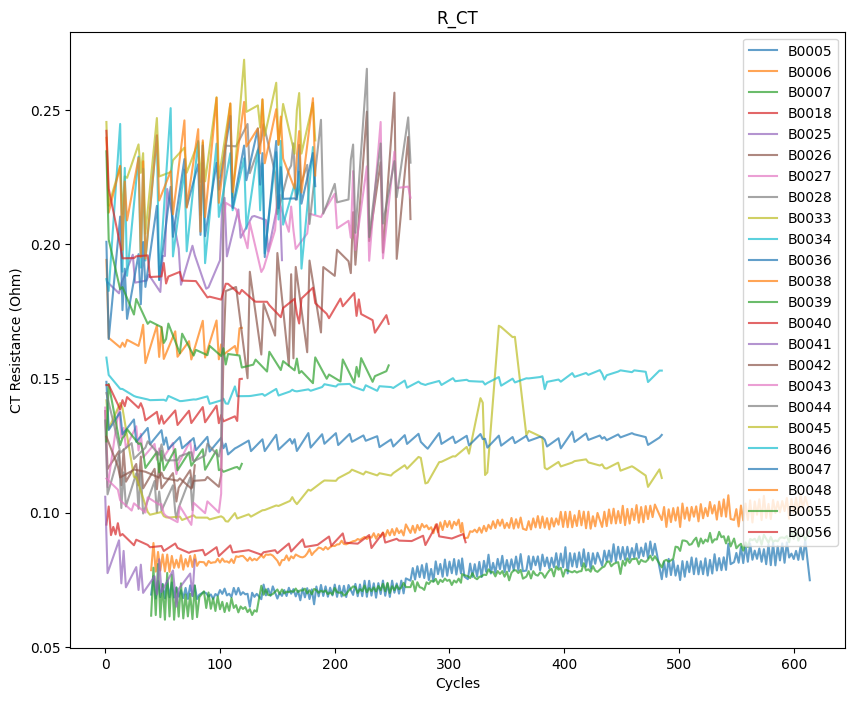

In [28]:
plt.figure(figsize=(10, 8))
for cell_id, group in eis_df.groupby("Cell_ID"):
        plt.plot(group["Cycle_Number"], group["R_Charge_Transfer"], label=cell_id, alpha=0.7)
plt.xlabel('Cycles')
plt.ylabel('CT Resistance (Ohm)')
plt.title('R_CT')
plt.legend()
plt.show()

In [29]:
charge_df.to_sql('CHARGE', conn, index=False, if_exists='replace')
discharge_df.to_sql('DISCHARGE', conn, index=False, if_exists='replace')
eis_df.to_sql('IMPEDANCE', conn, index=False, if_exists='replace')
rect_df.to_sql('RECT', conn, index=False, if_exists='replace')

68874

In [30]:
%%sql
SELECT Cell_ID, MIN(Cycle_Number) AS first_cycle
FROM DISCHARGE
GROUP BY Cell_ID;

 * sqlite:///mydb.sqlite
Done.


Cell_ID,first_cycle
B0005,1
B0006,1
B0007,1
B0018,2
B0025,3
B0026,3
B0027,3
B0028,3
B0033,0
B0034,0


In [31]:
%%sql SELECT
    Cell_ID,
    Cycle_Number,
    COUNT(Re_Battery_Impedance) as N_Freq_Points
FROM IMPEDANCE
WHERE Cell_ID = 'B0005'
GROUP BY Cell_ID, Cycle_Number;


 * sqlite:///mydb.sqlite
Done.


Cell_ID,Cycle_Number,N_Freq_Points
B0005,40,48
B0005,42,48
B0005,44,48
B0005,46,48
B0005,48,48
B0005,50,48
B0005,52,48
B0005,54,48
B0005,56,48
B0005,58,48


Here we see that the EIS performed in every cycle was done in 48 frequency points. We will assume that the points were spread out evenly in a logarithmic scale from 0.1 Hz to 5kHz (the frequency range was given in the dataset).

In [32]:
%%sql
SELECT
    D.Cell_ID,
    D.FirstCycle,
    I.FirstCycle,
    D.LastCycle,
    I.LastCycle,
    D.Cycle_Count,
    I.Cycle_Count
FROM
    (SELECT Cell_ID, MIN(Cycle_Number) AS FirstCycle, MAX(Cycle_Number) AS LastCycle, COUNT(DISTINCT Cycle_Number) AS Cycle_Count
     FROM DISCHARGE
     GROUP BY Cell_ID) AS D
JOIN
    (SELECT Cell_ID, MIN(Cycle_Number) AS FirstCycle, MAX(Cycle_Number) AS LastCycle, COUNT(DISTINCT Cycle_Number) AS Cycle_Count
     FROM IMPEDANCE
     GROUP BY Cell_ID) AS I
ON D.Cell_ID = I.Cell_ID;


 * sqlite:///mydb.sqlite
Done.


Cell_ID,FirstCycle,FirstCycle_1,LastCycle,LastCycle_1,Cycle_Count,Cycle_Count_1
B0005,1,40,613,614,168,278
B0006,1,40,613,614,168,278
B0007,1,40,613,614,168,278
B0018,2,1,318,314,132,53
B0025,3,0,77,78,28,21
B0026,3,0,77,78,28,21
B0027,3,0,77,78,28,21
B0028,3,0,77,78,28,21
B0033,0,1,482,485,197,92
B0034,0,1,482,485,197,92


Here we see that the number of cycles of impedance and discharge measurement are not equal, meaning that there are cycles without any impedance information. Therefore, we will try to fit the model that accounts the results of the EIS parameters, but removes all cycles without impedance results.

Next Steps:


1. Convert 0.1 - 5 kHz to 48 data points
2. EIS plot for each cycles, remove non log-KK data
2. Extract R_E, R_CT, and C_DL
3. Put back into DataFrame
4. Match it into the Discharge DF
6. Copy the DF, one that includes the EIS results and one that does not
7. Model using XGBoost, RandomForest, LightGBM, LSTM





In [33]:
#Creating the frequency array for Nyquist plot fit.

frequency = np.logspace(np.log10(0.1), np.log10(5000), 48)
print(frequency)

[1.00000000e-01 1.25886189e-01 1.58473325e-01 1.99496029e-01
 2.51137948e-01 3.16147991e-01 3.97986656e-01 5.01010233e-01
 6.30702688e-01 7.93967575e-01 9.99495520e-01 1.25822682e+00
 1.58393379e+00 1.99395387e+00 2.51011254e+00 3.15988500e+00
 3.97785880e+00 5.00757484e+00 6.30384511e+00 7.93567035e+00
 9.98991295e+00 1.25759207e+01 1.58313472e+01 1.99294796e+01
 2.50884624e+01 3.15829091e+01 3.97585205e+01 5.00504862e+01
 6.30066495e+01 7.93166697e+01 9.98487324e+01 1.25695764e+02
 1.58233606e+02 1.99194256e+02 2.50758057e+02 3.15669761e+02
 3.97384632e+02 5.00252367e+02 6.29748639e+02 7.92766560e+02
 9.97983608e+02 1.25632353e+03 1.58153781e+03 1.99093767e+03
 2.50631555e+03 3.15510512e+03 3.97184159e+03 5.00000000e+03]


In [34]:
!pip install impedance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.7 MB/s eta 0:00:00


In [35]:
rect_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68874 entries, 0 to 74411
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Cycle_Number            68874 non-null  int64         
 1   Time_abs                68874 non-null  datetime64[ns]
 2   Cell_ID                 68874 non-null  object        
 3   Ambient_Temperature     68874 non-null  int64         
 4   Re_Rectified_Impedance  68874 non-null  float64       
 5   Im_Rectified_Impedance  68874 non-null  float64       
 6   R_Electrolyte           68874 non-null  float64       
 7   R_Charge_Transfer       68874 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 4.7+ MB


In [36]:
discharge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687175 entries, 0 to 746333
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time_rel_s            687175 non-null  float64       
 1   Voltage_measured      687175 non-null  float64       
 2   Current_measured      687175 non-null  float64       
 3   Temperature_measured  687175 non-null  float64       
 4   Voltage_charge        687175 non-null  float64       
 5   Current_charge        687175 non-null  float64       
 6   Capacity              687175 non-null  float64       
 7   Cycle_Number          687175 non-null  int64         
 8   Ambient_Temperature   687175 non-null  int64         
 9   Cell_ID               687175 non-null  object        
 10  Time_abs              687175 non-null  datetime64[ns]
 11  Discharge_Type        687175 non-null  object        
 12  SoH                   687175 non-null  float64       
dtypes: d

In [37]:
alt_241 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_2-4-1']
alt_4124 = discharge_df[discharge_df['Discharge_Type'] == 'Alter_4-1-2-4']
const_1A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_1A']
const_2A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_2A']
const_4A = discharge_df[discharge_df['Discharge_Type'] == 'Constant_4A']
square_4A = discharge_df[discharge_df['Discharge_Type'] == 'Square_4A']
discharge_types = {
    "Alter_2-4-1": alt_241,
    "Alter_4-1-2-4": alt_4124,
    "Constant_1A": const_1A,
    "Constant_2A": const_2A,
    "Constant_4A": const_4A,
    "Square_4A": square_4A,
}

In [38]:
square_4A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65352 entries, 0 to 65351
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time_rel_s            65352 non-null  float64       
 1   Voltage_measured      65352 non-null  float64       
 2   Current_measured      65352 non-null  float64       
 3   Temperature_measured  65352 non-null  float64       
 4   Voltage_charge        65352 non-null  float64       
 5   Current_charge        65352 non-null  float64       
 6   Capacity              65352 non-null  float64       
 7   Cycle_Number          65352 non-null  int64         
 8   Ambient_Temperature   65352 non-null  int64         
 9   Cell_ID               65352 non-null  object        
 10  Time_abs              65352 non-null  datetime64[ns]
 11  Discharge_Type        65352 non-null  object        
 12  SoH                   65352 non-null  float64       
dtypes: datetime64[ns](1),

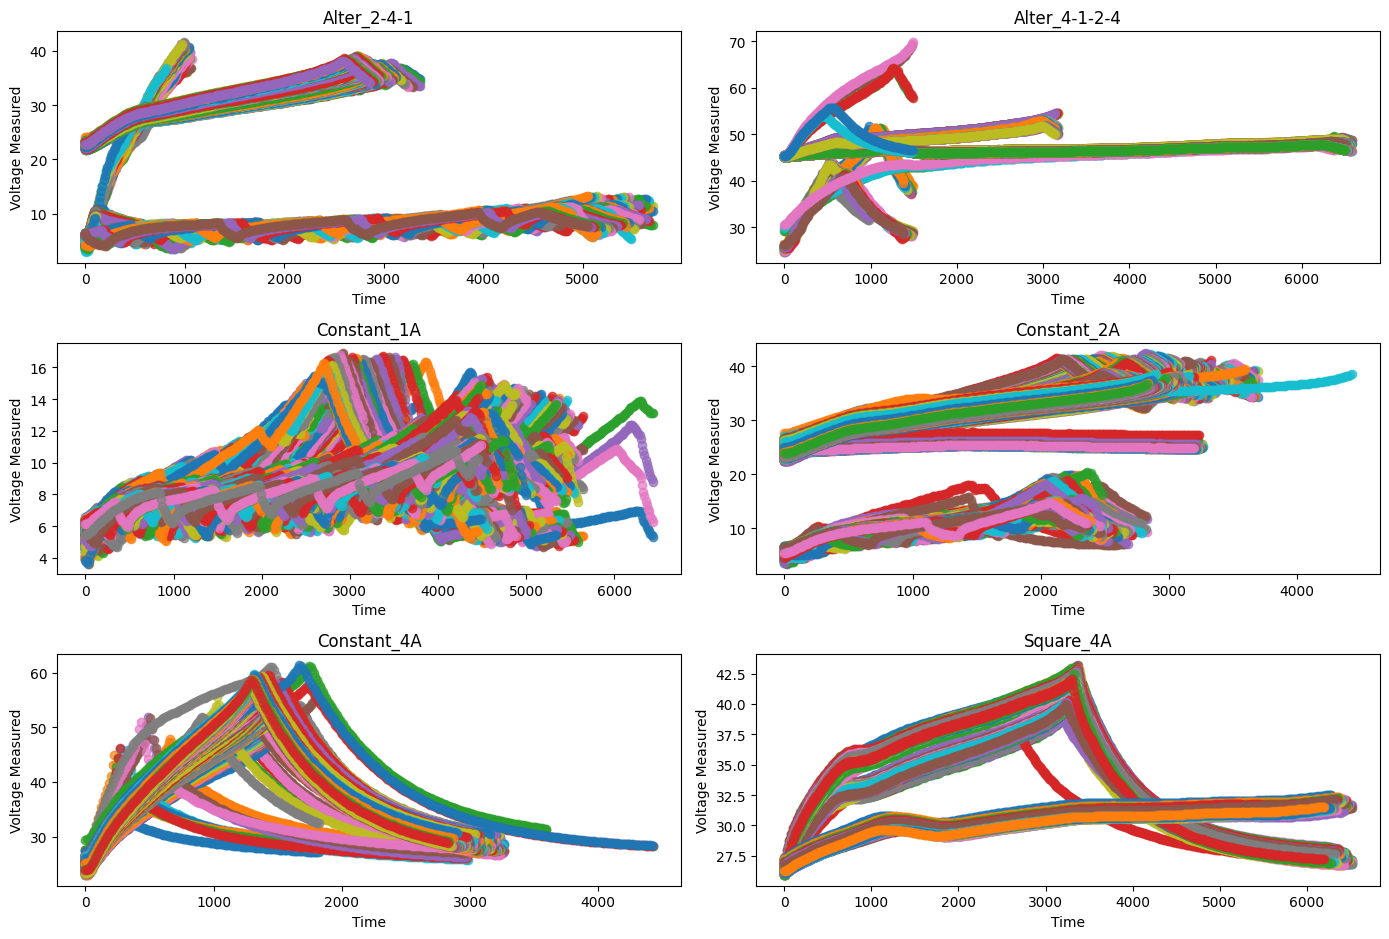

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (label, df) in zip(axes, discharge_types.items()):
    for (cell_id, cycle), group in df.groupby(["Cell_ID", "Cycle_Number"]):
        ax.scatter(group["Time_rel_s"], group["Temperature_measured"], label=f"{cell_id}-{cycle}", alpha=0.7)
    ax.set_title(label)
    ax.set_xlabel("Time")
    ax.set_ylabel("Voltage Measured")
    #ax.legend(fontsize="small", loc="best", ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [40]:
discharge_df['Discharge_Type'].value_counts()

,count
Discharge_Type,
Constant_2A,278110
Constant_1A,98076
Constant_4A,94130
Alter_2-4-1,77385
Square_4A,65352
Alter_4-1-2-4,60603
Alter_4-1,13519


In [41]:
discharge_sum_df = (
    discharge_df
    .groupby(["Cell_ID", "Cycle_Number"])
    .agg({
        "Time_rel_s": lambda x: x.max() - x.min(),
        "Discharge_Type": "first",
        "Voltage_measured": lambda x: x.iloc[0] - x.iloc[-1],
        "Current_measured": "min",
        "Temperature_measured": lambda x: x.max() - x.iloc[0],
        "Ambient_Temperature": "mean",
        "Voltage_charge": "mean",
        "Current_charge": "mean",
        "Capacity": "mean",
        "SoH": "mean"
    })
    .reset_index()
)


In [42]:
discharge_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cell_ID               2375 non-null   object 
 1   Cycle_Number          2375 non-null   int64  
 2   Time_rel_s            2375 non-null   float64
 3   Discharge_Type        2375 non-null   object 
 4   Voltage_measured      2375 non-null   float64
 5   Current_measured      2375 non-null   float64
 6   Temperature_measured  2375 non-null   float64
 7   Ambient_Temperature   2375 non-null   float64
 8   Voltage_charge        2375 non-null   float64
 9   Current_charge        2375 non-null   float64
 10  Capacity              2375 non-null   float64
 11  SoH                   2375 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 222.8+ KB


In [43]:
eis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84768 entries, 0 to 91583
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Cycle_Number          84768 non-null  int64         
 1   Time_abs              84768 non-null  datetime64[ns]
 2   Cell_ID               84768 non-null  object        
 3   Ambient_Temperature   84768 non-null  int64         
 4   Re_Sense_Current      84768 non-null  float64       
 5   Im_Sense_Current      84768 non-null  float64       
 6   Re_Battery_Current    84768 non-null  float64       
 7   Im_Battery_Current    84768 non-null  float64       
 8   Re_Current_Ratio      84768 non-null  float64       
 9   Im_Current_Ratio      84768 non-null  float64       
 10  Re_Battery_Impedance  84768 non-null  float64       
 11  Im_Battery_Impedance  84768 non-null  float64       
 12  R_Electrolyte         84768 non-null  float64       
 13  R_Charge_Transfer    

In [44]:
eis_sum_df = (
    eis_df
    .groupby(["Cell_ID", "Cycle_Number"])
    .agg({
        "Ambient_Temperature":"mean",
        "R_Electrolyte": "mean",
        "R_Charge_Transfer": "mean"
    })
    .reset_index()
)

eis_sum_df.head()



,Cell_ID,Cycle_Number,Ambient_Temperature,R_Electrolyte,R_Charge_Transfer
0,B0005,40,24.0,0.044669,0.069456
1,B0005,42,24.0,0.046687,0.076275
2,B0005,44,24.0,0.044843,0.067972
3,B0005,46,24.0,0.046195,0.074534
4,B0005,48,24.0,0.045101,0.068528


In [45]:
eis_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cell_ID              1766 non-null   object 
 1   Cycle_Number         1766 non-null   int64  
 2   Ambient_Temperature  1766 non-null   float64
 3   R_Electrolyte        1766 non-null   float64
 4   R_Charge_Transfer    1766 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 69.1+ KB


In [46]:
eis_dis = eis_sum_df.copy()
eis_dis['Cycle_Number'] = eis_dis['Cycle_Number'] - 1

eis_charge = eis_sum_df.copy()
eis_charge['Cycle_Number'] = eis_charge['Cycle_Number'] + 1

# Merge discharge info
discharge_eis_df = discharge_sum_df.merge(
    eis_dis[['Cell_ID', 'Cycle_Number', 'R_Electrolyte', 'R_Charge_Transfer']],
    on=['Cell_ID', 'Cycle_Number'],
    how='left'
)
discharge_eis_df.rename(columns={
    'R_Electrolyte': 're_dis',
    'R_Charge_Transfer': 'rct_dis'
}, inplace=True)

# Merge charge info
discharge_eis_df = discharge_eis_df.merge(
    eis_charge[['Cell_ID', 'Cycle_Number', 'R_Electrolyte', 'R_Charge_Transfer']],
    on=['Cell_ID', 'Cycle_Number'],
    how='left'
)
discharge_eis_df.rename(columns={
    'R_Electrolyte': 're_charge',
    'R_Charge_Transfer': 'rct_charge'
}, inplace=True)

discharge_eis_df.head()

,Cell_ID,Cycle_Number,Time_rel_s,Discharge_Type,Voltage_measured,Current_measured,Temperature_measured,Ambient_Temperature,Voltage_charge,Current_charge,Capacity,SoH,re_dis,rct_dis,re_charge,rct_charge
0,B0005,1,3690.234,Constant_2A,0.914322,-2.018015,14.652147,24.0,2.404944,-1.805570,1.856487,1.000000,NaN,NaN,NaN,NaN
1,B0005,3,3672.344,Constant_2A,0.889528,-2.016821,14.335646,24.0,2.399260,-1.804583,1.846327,0.994527,NaN,NaN,NaN,NaN
2,B0005,5,3651.641,Constant_2A,0.860736,-2.016574,14.084531,24.0,2.397969,-1.803575,1.835349,0.988614,NaN,NaN,NaN,NaN
3,B0005,7,3631.563,Constant_2A,0.874279,-2.015936,14.108068,24.0,2.408289,-1.812863,1.835263,0.988567,NaN,NaN,NaN,NaN
4,B0005,9,3629.172,Constant_2A,0.882802,-2.017426,14.140596,24.0,2.408505,-1.812876,1.834646,0.988235,NaN,NaN,NaN,NaN


In [47]:
# Create columns in discharge_sum_df
dis_sum_df = discharge_sum_df.copy()

In [48]:
info_df = pd.DataFrame({
    'dtype': discharge_eis_df.dtypes,
    'num_nulls': discharge_eis_df.isnull().sum(),
    'num_non_null': discharge_eis_df.notnull().sum()
})
info_df


,dtype,num_nulls,num_non_null
Cell_ID,object,0,2375
Cycle_Number,int64,0,2375
Time_rel_s,float64,0,2375
Discharge_Type,object,0,2375
Voltage_measured,float64,0,2375
Current_measured,float64,0,2375
Temperature_measured,float64,0,2375
Ambient_Temperature,float64,0,2375
Voltage_charge,float64,0,2375
Current_charge,float64,0,2375


In [49]:
discharge_eis_clean = discharge_eis_df.dropna()
discharge_eis_clean = discharge_eis_clean[[c for c in discharge_eis_df.columns if c not in ['Capacity','SoH']] + ['Capacity','SoH']]

discharge_eis_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 508 entries, 19 to 2362
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cell_ID               508 non-null    object 
 1   Cycle_Number          508 non-null    int64  
 2   Time_rel_s            508 non-null    float64
 3   Discharge_Type        508 non-null    object 
 4   Voltage_measured      508 non-null    float64
 5   Current_measured      508 non-null    float64
 6   Temperature_measured  508 non-null    float64
 7   Ambient_Temperature   508 non-null    float64
 8   Voltage_charge        508 non-null    float64
 9   Current_charge        508 non-null    float64
 10  re_dis                508 non-null    float64
 11  rct_dis               508 non-null    float64
 12  re_charge             508 non-null    float64
 13  rct_charge            508 non-null    float64
 14  Capacity              508 non-null    float64
 15  SoH                   508 

Correlation Matrix (with EIS results)

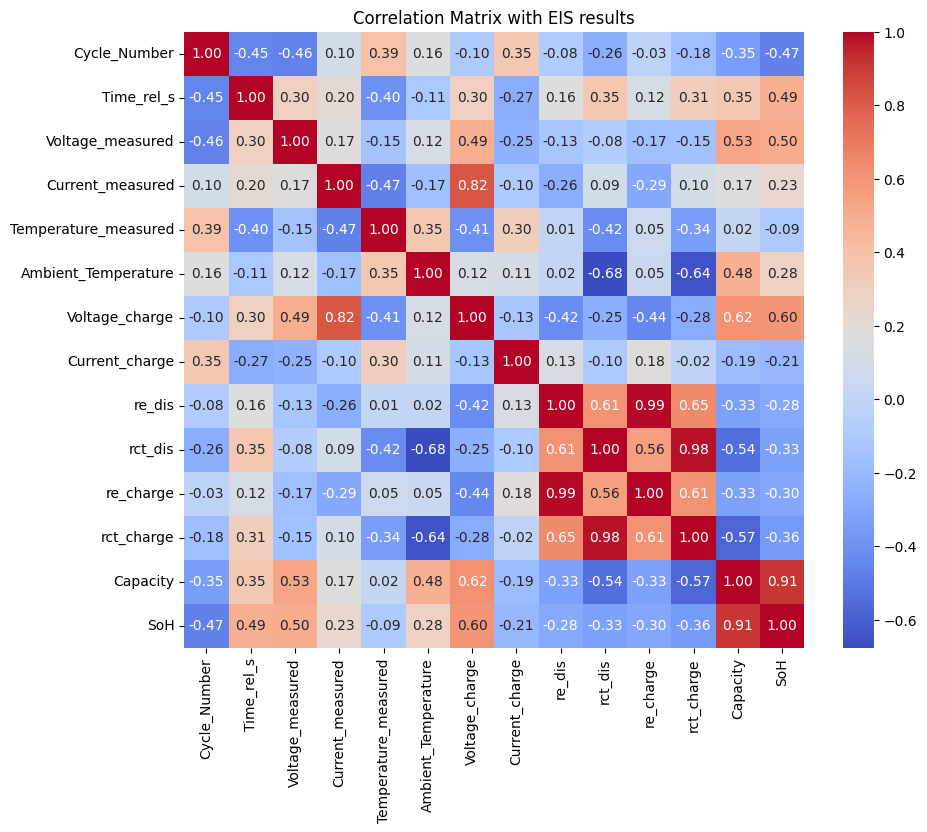

In [50]:
numeric_df = discharge_eis_clean.select_dtypes(include='number')
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
seaborn.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix with EIS results")
plt.show()

We observe that (ignoring the Capacity as SoH is directly determined by it) there is a great positive correlation between Time_rel_s, measured and load voltages and currents with the SoH. The EIS parameters, R_Electrolyte and R_Charge_Transfer have negative correlation with the SoH. We will now make a model with both dataframes.

Correlation Matrix (without EIS results)

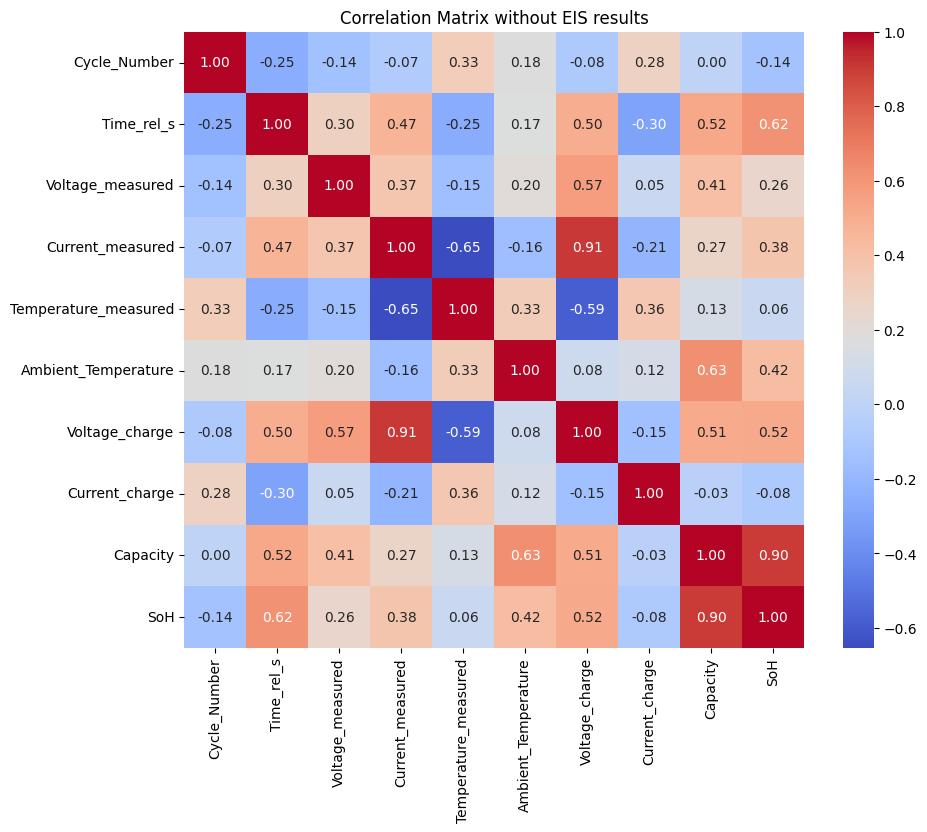

In [51]:
numeric_df1 = dis_sum_df.select_dtypes(include='number')
corr_matrix1 = numeric_df1.corr()
plt.figure(figsize=(10, 8))
seaborn.heatmap(numeric_df1.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix without EIS results")
plt.show()

Turning Discharge Types into dummy variables.

In [52]:
dis_sum_df = pd.get_dummies(dis_sum_df, columns=['Discharge_Type'], drop_first=True)
dis_sum_df.drop(columns=['Capacity'], inplace=True)
dis_sum_df.head()

,Cell_ID,Cycle_Number,Time_rel_s,Voltage_measured,Current_measured,Temperature_measured,Ambient_Temperature,Voltage_charge,Current_charge,SoH,Discharge_Type_Alter_4-1,Discharge_Type_Alter_4-1-2-4,Discharge_Type_Constant_1A,Discharge_Type_Constant_2A,Discharge_Type_Constant_4A,Discharge_Type_Square_4A
0,B0005,1,3690.234,0.914322,-2.018015,14.652147,24.0,2.404944,-1.805570,1.000000,False,False,False,True,False,False
1,B0005,3,3672.344,0.889528,-2.016821,14.335646,24.0,2.399260,-1.804583,0.994527,False,False,False,True,False,False
2,B0005,5,3651.641,0.860736,-2.016574,14.084531,24.0,2.397969,-1.803575,0.988614,False,False,False,True,False,False
3,B0005,7,3631.563,0.874279,-2.015936,14.108068,24.0,2.408289,-1.812863,0.988567,False,False,False,True,False,False
4,B0005,9,3629.172,0.882802,-2.017426,14.140596,24.0,2.408505,-1.812876,0.988235,False,False,False,True,False,False


In [53]:
discharge_eis_clean = pd.get_dummies(discharge_eis_clean, columns=['Discharge_Type'], drop_first=True)
discharge_eis_clean.drop(columns=['Capacity'], inplace=True)
discharge_eis_clean.head()

,Cell_ID,Cycle_Number,Time_rel_s,Voltage_measured,Current_measured,Temperature_measured,Ambient_Temperature,Voltage_charge,Current_charge,re_dis,rct_dis,re_charge,rct_charge,SoH,Discharge_Type_Alter_4-1,Discharge_Type_Alter_4-1-2-4,Discharge_Type_Constant_1A,Discharge_Type_Constant_2A,Discharge_Type_Constant_4A,Discharge_Type_Square_4A
19,B0005,41,3591.734,0.928874,-2.016847,13.888784,24.0,2.448323,-1.842201,0.046687,0.076275,0.044669,0.069456,0.994904,False,False,False,True,False,False
20,B0005,45,3552.297,0.969583,-2.016191,14.070169,24.0,2.474068,-1.861526,0.046195,0.074534,0.044843,0.067972,0.995114,False,False,False,True,False,False
21,B0005,49,3531.578,0.930138,-2.016760,13.948276,24.0,2.480037,-1.860800,0.045991,0.073427,0.045101,0.068528,0.989060,False,False,False,True,False,False
22,B0005,53,3492.907,0.907087,-2.016023,13.949235,24.0,2.492449,-1.870012,0.045217,0.074648,0.044172,0.068044,0.983460,False,False,False,True,False,False
23,B0005,57,3511.594,0.907673,-2.017191,14.110271,24.0,2.479261,-1.860064,0.044910,0.073957,0.043787,0.068450,0.983100,False,False,False,True,False,False


Using EIS results

In [54]:
#Separating by cell ID to prevent data leakage
cell_ids = discharge_eis_clean['Cell_ID'].unique()
train_ids, test_ids = train_test_split(cell_ids, test_size=0.3, random_state=42)
#val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = discharge_eis_clean[discharge_eis_clean['Cell_ID'].isin(train_ids)].copy()
#val_df   = discharge_eis_clean[discharge_eis_clean['Cell_ID'].isin(val_ids)].copy()
test_df  = discharge_eis_clean[discharge_eis_clean['Cell_ID'].isin(test_ids)].copy()

categorical_cols = ['Cell_ID']

train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
#val_df   = pd.get_dummies(val_df, columns=categorical_cols, drop_first=True)
test_df  = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

#val_df = val_df.reindex(columns=train_df.columns, fill_value=0)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

X_train = train_df.drop(columns=['SoH'])
y_train = train_df['SoH']
'''
X_val = val_df.drop(columns=['SoH'])
y_val = val_df['SoH']
'''
X_test = test_df.drop(columns=['SoH'])
y_test = test_df['SoH']

print("Training features shape:", X_train.shape)

print("Test features shape:", X_test.shape)

Training features shape: (216, 33)
Test features shape: (292, 33)


In [55]:
def get_pipeline(model_name):
    """
    model_name: 'rf', 'xgb', 'lgb'
    """
    if model_name == 'rf':
        return Pipeline([
            ('scaler', StandardScaler()),  # optional for tree-based models
            ('model', RandomForestRegressor(n_estimators=100, random_state=42))
        ])

    elif model_name == 'xgb':
        return Pipeline([
            ('scaler', StandardScaler()),  # optional
            ('model', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
        ])

    elif model_name == 'lgb':
        return Pipeline([
                        ('model', LGBMRegressor(n_estimators=100, max_depth=-1, learning_rate=0.1, random_state=42))
        ])

    else:
        raise ValueError("model_name must be one of: 'rf', 'xgb', 'lgb'")

rf_pipeline = get_pipeline('rf')
xgb_pipeline = get_pipeline('xgb')
lgb_pipeline = get_pipeline('lgb')

In [56]:
from sklearn.model_selection import KFold

In [57]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [58]:
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

xg_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 1.0]
}

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10],
    'model__learning_rate': [0.05, 0.1],
    'model__num_leaves': [31, 50],
    'model__min_child_samples': [5, 10]
}

Random Forest Regressor

In [59]:
rf_model = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=2)
rf_model.fit(X_train, y_train)
print("Best parameters:", rf_model.best_params_)
print("Best score (MSE):", -rf_model.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.6s
[CV] END model__max_

In [60]:
def regression_report(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    return r2, mse, rmse, mae

In [61]:
y_pred_rf = rf_model.predict(X_test)
regression_report(y_test, y_pred_rf)

R²: 0.4750
MSE: 0.0095
RMSE: 0.0977
MAE: 0.0669


(0.47500918282599647,
 0.009541935333303168,
 np.float64(0.09768283028917195),
 0.06689804643667618)

XGBoost

In [62]:
xg_model = GridSearchCV(estimator=xgb_pipeline, param_grid=xg_param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=2)
xg_model.fit(X_train, y_train)
print("Best parameters:", xg_model.best_params_)
print("Best score (MSE):", -xg_model.best_score_)
y_pred_xg = xg_model.predict(X_test)
regression_report(y_test, y_pred_xg)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.7; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.7; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.7; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.7; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.7; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, mod

(0.6114341061168914,
 0.007062353303850053,
 np.float64(0.08403780877587215),
 0.06143228333653782)

LightGBM

In [63]:
lg_model = GridSearchCV(estimator=lgb_pipeline, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=2)
lg_model.fit(X_train, y_train)
print("Best parameters:", lg_model.best_params_)
print("Best score (MSE):", -lg_model.best_score_)
y_pred_lg = lg_model.predict(X_test)
regression_report(y_test, y_pred_lg)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

(0.6441013070481358,
 0.006468612787618049,
 np.float64(0.08042768669816414),
 0.05460299154908771)

R²: 0.4750
MSE: 0.0095
RMSE: 0.0977
MAE: 0.0669
R²: 0.6114
MSE: 0.0071
RMSE: 0.0840
MAE: 0.0614
R²: 0.6441
MSE: 0.0065
RMSE: 0.0804
MAE: 0.0546


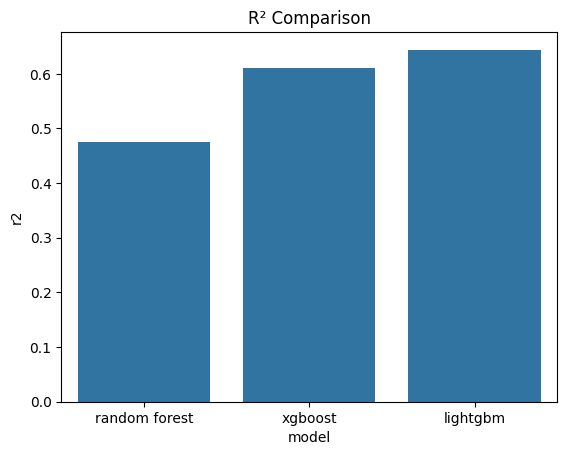

In [64]:
r2 = []
mse = []
rmse = []
mae = []
r2_rf, mse_rf, rmse_rf, mae_rf = regression_report(y_test, y_pred_rf)
r2.append(r2_rf)
mse.append(mse_rf)
rmse.append(rmse_rf)
mae.append(mae_rf)
r2_xg, mse_xg, rmse_xg, mae_xg = regression_report(y_test, y_pred_xg)
r2.append(r2_xg)
mse.append(mse_xg)
rmse.append(rmse_xg)
mae.append(mae_xg)
r2_lg, mse_lg, rmse_lg, mae_lg = regression_report(y_test, y_pred_lg)
r2.append(r2_lg)
mse.append(mse_lg)
rmse.append(rmse_lg)
mae.append(mae_lg)

results_df = pd.DataFrame({
    "model": ["random forest", "xgboost", "lightgbm"],
    "r2": r2,
    "mse": mse,
    "rmse": rmse,
    "mae": mae
})


sns.barplot(data=results_df, x="model", y="r2")
plt.title("R² Comparison")
plt.show()


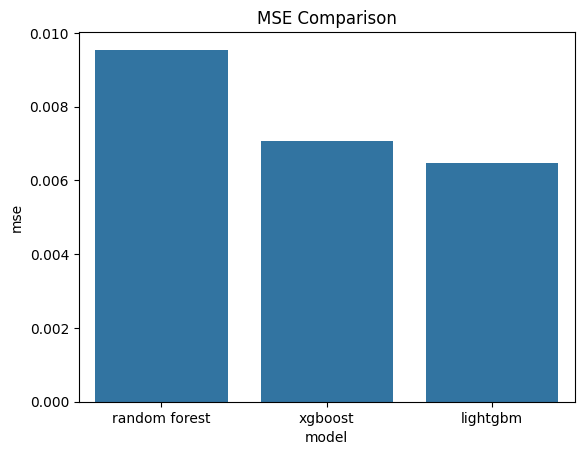

In [66]:
sns.barplot(data=results_df, x="model", y="mse")
plt.title("MSE Comparison")
plt.show()